<a href="https://colab.research.google.com/github/neonithinar/Language_detection/blob/main/Language_Identification_Project_preliminary_try_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem Statement

Develop a language detection engine, which can take in a snippet of text and predict which language it is written in. Google uses such a model in chrome browser to automatically translate foreign languages to your preferred language. 

Create a basic web app with a text input box. The user types in a sentence in any language and you should use the model to predict and output the correct language.

# Language identification using N-grams
 Particularly we will be using trigrams for this project. That is 3 consequtive words that occur in the language. As suggested by many literary works n-grams are a very efficient way to identify the language.
  This [dataset](https://downloads.tatoeba.org/exports/sentences.csv) is hosted by Tatoeba 

In [1]:
# Common Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import pickle
import tensorflow as tf
from tensorflow import keras
# from sklearn.preprocessing import MinMaxScaler

In [6]:
# Download the dataset
! wget https://downloads.tatoeba.org/exports/sentences.csv

--2021-02-08 18:13:11--  https://downloads.tatoeba.org/exports/sentences.csv
Resolving downloads.tatoeba.org (downloads.tatoeba.org)... 94.130.77.194
Connecting to downloads.tatoeba.org (downloads.tatoeba.org)|94.130.77.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 508779090 (485M) [application/octet-stream]
Saving to: ‘sentences.csv.1’

sentences.csv.1     100%[===================>] 485.21M  31.1MB/s    in 16s     

2021-02-08 18:13:27 (30.2 MB/s) - ‘sentences.csv.1’ saved [508779090/508779090]



In [7]:
#read data
df = pd.read_csv("sentences.csv", sep= '\t', encoding= 'utf8', index_col= 0, names=['lang', 'text'])
length_condition = [True if 20 <= len(sen) <= 200 else False for sen in df['text']]

df = df[length_condition]


In [4]:
df.head()

,lang,text
5,cmn,今天是６月１８号，也是Muiriel的生日！
21,cmn,选择什么是“对”或“错”是一项艰难的任务，我们却必须要完成它。
67,cmn,我们看东西不是看其实质，而是以我们的主观意识看它们的。
71,cmn,生活就是當你忙著進行你的計劃時總有其他的事情發生。
77,deu,Lass uns etwas versuchen!


In [ ]:
df['lang'].unique()

array(['cmn', 'deu', 'rus', 'fra', 'eng', 'spa', 'ita', 'jpn', 'kor',
       'vie', 'nld', 'epo', 'por', 'tur', 'heb', 'ell', 'ind', 'ara',
       'arz', 'fin', 'bul', 'swe', 'ukr', 'bel', 'que', 'ces', 'nno',
       'nob', 'zsm', 'est', 'kat', 'pol', 'lat', 'yue', 'swh', 'sqi',
       'hun', 'isl', 'wuu', 'fry', 'afr', 'ron', 'fao', 'san', 'bre',
       'tat', 'yid', 'uig', 'uzb', 'srp', 'qya', 'pes', nan, 'slk', 'eus',
       'cycl', 'dan', 'acm', 'lvs', 'kaz', 'hye', 'hin', 'ben', 'cat',
       'bos', 'hrv', 'lit', 'tha', 'urd', 'orv', 'cha', 'tgl', 'mon',
       'scn', 'gle', 'slv', 'frm', 'glg', 'vol', 'jbo', 'toki', 'ina',
       'nds', 'mal', 'tlh', 'roh', 'lzh', 'ltz', 'oss', 'ido', 'gla',
       'mlt', 'ast', 'oci', 'ile', 'ota', 'xal', 'tel', 'sjn', 'nov',
       'khm', 'tpi', 'ang', 'aze', 'tgk', 'tuk', 'chv', 'mkd', 'hsb',
       'dsb', 'sme', 'cym', 'mri', 'ksh', 'kmr', 'ewe', 'ber', 'udm',
       'lld', 'pms', 'lad', 'grn', 'mlg', 'xho', 'pnb', 'grc', 'npi',
       'tpw',

There are 370 unique languages in this dataset. Taking only 10 languages for simplicity

In [8]:
languages = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages
# lang1 = ['deu', 'eng', 'fra', 'ita', 'por', 'spa', 'rus','hun', 'jpn', 'ukr'] 
# lang2 = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe',  'lvs' 'hin', 'dan','srp'] # 10 languages
# lang3 = ['tur', 'epo', 'cmn' , 'pes', 'kab', 'mar', 'heb', 'bul', 'ron', 'ell'] # 10 languages
# 
#   'ara','mkd'
#              
# we will be missing the Lativan and slovakian and slovene language from europarl

In [9]:
total_lang = df['lang'].unique()
for i in languages:
  print(i in total_lang)

True
True
True
True
True
True
True
True
True
True


In [10]:


# lang = ['bulg', 'dani','germ', 'gree', 'span', 'esto', 'finn', 'fren', 'hung', 'ital',
#         'lith', 'latv', 'dutc', 'poli', 'port', 'roma', 'slvk', 'slve', 'swed']
df = df[df['lang'].isin(languages)]
# df.info()
# df.head()
# df['lang'].unique()



# trim the dataset
df_trim = pd.DataFrame(columns=['lang', 'text'])

for l in languages:
  lang_trim = df[df['lang'] == l].sample(50000, random_state = 42, replace = True)
  df_trim = df_trim.append(lang_trim)

# Create random train, val, and test set

df_shuffle = df_trim.sample(frac = 1)
df_shuffle.shape


(500000, 2)

In [11]:
df_shuffle.head()

,lang,text
4147685,mkd,Отсекогаш сум мислел дека ќе ми биде страв.
8565563,fin,Mari yritti muuttaa Tomin oravaksi käyttäen lo...
9663007,swe,De avlägsnade en njure
4840298,fin,Tomi voi hoitaa sen.
3487077,dan,Her er et spørgeskema som jeg gerne vil have d...


Hmm... maybe we should add stratified shuffling so that the train, test and validation sets would be an accurate representation of the original dataframe

In [ ]:
# import string
# import re
# from pickle import dump
# from unicodedata import normalize

In [ ]:
# def clean_text(lines):
# 	cleaned = list()
# 	# prepare regex for char filtering
# 	re_print = re.compile('[^%s]' % re.escape(string.printable))
# 	# prepare translation table for removing punctuation
# 	table = str.maketrans('', '', string.punctuation)
# 	for line in lines:
# 		# normalize unicode characters
# 		# line = normalize('NFD', line).encode('ascii', 'ignore')
# 		# line = line.decode('UTF-8')
# 		# tokenize on white space
# 		line = line.split()
# 		# convert to lower case
# 		line = [word.lower() for word in line]
# 		# remove punctuation from each token
# 		line = [word.translate(table) for word in line]
# 		# remove non-printable chars form each token
# 		line = [re_print.sub('', w) for w in line]
# 		# remove tokens with numbers in them
# 		line = [word for word in line if word.isalpha()]
# 		# store as string
# 		cleaned.append(' '.join(line))
# 	return cleaned

In [12]:
df_shuffle.head()

,lang,text
4147685,mkd,Отсекогаш сум мислел дека ќе ми биде страв.
8565563,fin,Mari yritti muuttaa Tomin oravaksi käyttäen lo...
9663007,swe,De avlägsnade en njure
4840298,fin,Tomi voi hoitaa sen.
3487077,dan,Her er et spørgeskema som jeg gerne vil have d...


In [13]:
df_shuffle["text"] = df_shuffle["text"].str.lower()
df_shuffle["text"] = df_shuffle['text'].str.replace(r'[^\w\s]+', '')

In [14]:
df_shuffle.head()

,lang,text
4147685,mkd,отсекогаш сум мислел дека ќе ми биде страв
8565563,fin,mari yritti muuttaa tomin oravaksi käyttäen lo...
9663007,swe,de avlägsnade en njure
4840298,fin,tomi voi hoitaa sen
3487077,dan,her er et spørgeskema som jeg gerne vil have d...


# Stratified Shuffle split ?

Since the number of sentences for different languages are different, A well shuffled dataset would not be 

In [15]:
train_set = df_shuffle[:210000]
validation_set = df_shuffle[210000: 270000]
test_set = df_shuffle[270000:300000]


In [ ]:
train_set.shape

(210000, 2)

In [ ]:
# Let's save the data find currently using variables in python
train_set.to_csv('train.csv')
validation_set.to_csv('valid.csv')
test_set.to_csv('test.csv')

After saving let's reset the runtime and load the train, test and validation sets. so that Ram usage is reduced


In [ ]:
train_set = pd.read_csv("train.csv")
validation_set = pd.read_csv("valid.csv")
test_set =pd.read_csv("test.csv")

# Feature Engineering


In [ ]:
print(len(train_set), len(validation_set), len(test_set))

210000 60000 30000


In [ ]:
train_set.head()

,lang,text
3125066,swe,den här filmen är inte alls bra jo det är den
9257999,dan,min far gav mig en ny fyldepen
3287628,srp,zabava je bila uspešna
563455,lit,vyras paėmė berniuką už rankos
8260182,nld,ik vraag me af of ik tom echt de waarheid moet...


In [16]:
def get_trigrams(corpus, num_features = 200):
  """ Returns a list of N most commmon trigrams from a list of 
      sentences:
      corpus: List of strings
      num_features: (int) number of features
      """
  vectorizer = CountVectorizer(analyzer= "char", ngram_range= (3, 3), max_features= num_features)
  X = vectorizer.fit_transform(corpus)

  feature_names = vectorizer.get_feature_names()
  return feature_names


In [17]:
# get Trigrams for each language

features = {}
feature_set = set()

for l in languages:
  corpus = train_set[train_set.lang == l]['text']
  # get 200 most frequent trigrams. (num of features can be changed by changing num_features)
  trigrams = get_trigrams(corpus, num_features= 200)
  features[l] = trigrams
  feature_set.update(trigrams)



In [18]:
# create a vocabulary using feature set
vocab = dict()
for i, f in enumerate(feature_set):
  vocab[f] = i


In [ ]:
len(features['swe'])


200

**save the vocabulary**

In [ ]:
file_to_write = open("vocab.pkl", "wb")
pickle.dump(vocab, file_to_write)

In [19]:
# train count vectorizer using the vocabulary
vectorizer = CountVectorizer(analyzer= 'char', ngram_range= (3, 3), vocabulary= vocab)

# create feature matrix for   training set
corpus = train_set['text']
X = vectorizer.fit_transform(corpus)
feature_names = vectorizer.get_feature_names()
train_features = pd.DataFrame(data = X.toarray(), columns = feature_names)


Save train_features to csv

On the previous run the colab notebook crashed because of out of memory error
By this time the ram is almost completely full. maybe I should write this files into a csv


In [20]:
print(len(train_features.columns))
train_features.head()

1336


,ma,pi,cz,rzy,eik,o d,obi,s t,ysl,tt,ضل,ك أ,الس,ou,ive,كن,ا ي,vat,no,wee,mn,i j,еше,me,my,ise,we,nå,r i,ен,zo,هل,on,lis,ше,рав,e k,ede,nde,n s,...,ни,dži,ник,ја,av,ال,eke,как,ink,ik,ić,أم,utt,олк,си,itt,ssä,на,aan,kas,ies,ве,ret,oc,еба,wo,ger,asi,ا ع,ког,oit,ни,ба,aš,ة ف,ave,m w,dzi,or,ng
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


This cell always crashes during execution

In [21]:
# Add the target variable
train_features['lang'] = list(train_set['lang'])

Let's try standard scaler instead

In [22]:
def feature_matrix_scaled(df):
  corpus = df['text']
  X = vectorizer.fit_transform(corpus)
  df_feat = pd.DataFrame(data= X.toarray(), columns=feature_names)
  # df_feat = (df_feat - train_min) / (train_max - train_min)
  # add target var
  df_feat['lang'] = list(df['lang'])
  return df_feat
  

In [23]:
train_features = feature_matrix_scaled(train_set)

In [24]:
valid_feat = feature_matrix_scaled(validation_set)
valid_feat.head()

,ma,pi,cz,rzy,eik,o d,obi,s t,ysl,tt,ضل,ك أ,الس,ou,ive,كن,ا ي,vat,no,wee,mn,i j,еше,me,my,ise,we,nå,r i,ен,zo,هل,on,lis,ше,рав,e k,ede,nde,n s,...,dži,ник,ја,av,ال,eke,как,ink,ik,ić,أم,utt,олк,си,itt,ssä,на,aan,kas,ies,ве,ret,oc,еба,wo,ger,asi,ا ع,ког,oit,ни,ба,aš,ة ف,ave,m w,dzi,or,ng,lang
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,ara
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nld
2,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,pol
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,pol
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,fin


In [25]:
test_feat = feature_matrix_scaled(test_set)


# Nulling usedvariables 

In [ ]:
%whos

Variable                Type               Data/Info
----------------------------------------------------
CountVectorizer         type               <class 'sklearn.feature_e<...>on.text.CountVectorizer'>
MinMaxScaler            type               <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
X                       csr_matrix           (0, 46)	1\n  (0, 86)	1\<...>18)	1\n  (209999, 1251)	1
accuracy_score          function           <function accuracy_score at 0x7fb99ed3e840>
confusion_matrix        function           <function confusion_matrix at 0x7fb99ed3e8c8>
corpus                  Series             3125066        den här fi<...>th: 210000, dtype: object
df                      DataFrame                  lang             <...>[573522 rows x 2 columns]
df_shuffle              DataFrame                  lang             <...>[500000 rows x 2 columns]
df_trim                 DataFrame                  lang             <...>[500000 rows x 2 columns]
f                       s

In [26]:
df = []
df_trim = []
df_shuffle = []


In [ ]:
%whos

Variable                Type               Data/Info
----------------------------------------------------
CountVectorizer         type               <class 'sklearn.feature_e<...>on.text.CountVectorizer'>
MinMaxScaler            type               <class 'sklearn.preproces<...>sing._data.MinMaxScaler'>
X                       csr_matrix           (0, 46)	1\n  (0, 86)	1\<...>18)	1\n  (209999, 1251)	1
accuracy_score          function           <function accuracy_score at 0x7fb99ed3e840>
confusion_matrix        function           <function confusion_matrix at 0x7fb99ed3e8c8>
corpus                  Series             3125066        den här fi<...>th: 210000, dtype: object
df                      list               n=0
df_shuffle              list               n=0
df_trim                 list               n=0
f                       str                iek
feature_matrix_scaled   function           <function feature_matrix_<...>scaled at 0x7fb9699729d8>
feature_names           list       

# save the feature columns 
save and restart the runtime

In [ ]:
train_features.to_csv("train_features.csv")
test_feat.to_csv("test_feat.csv")
valid_feat.to_csv("valid_feat.csv")


In [ ]:
# Load the features again

train_features = pd.read_csv("train_features.csv")
test_feat = pd.read_csv("test_feat.csv")
valid_feat = pd.read_csv("valid_feat.csv")

In [ ]:
print(len(valid_feat.columns),len(test_feat.columns))
print(len(train_features),len(valid_feat),len(test_feat))

1354 1354
210000 60000 30000


# Exploratory Data Analysis

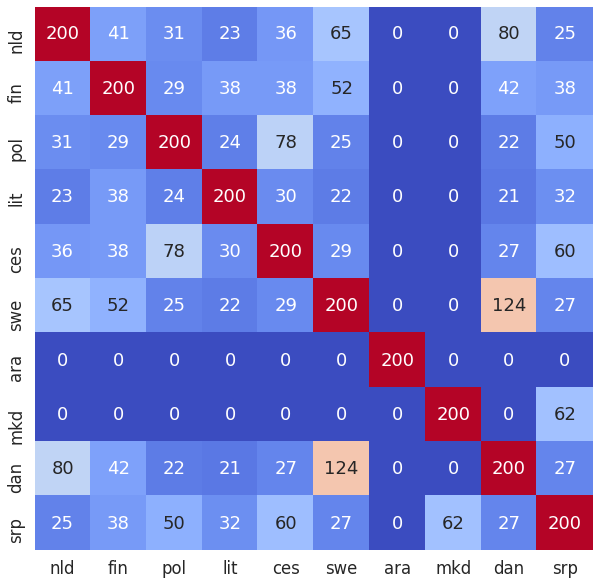

In [27]:
#Calculate number of shared trigrams
labels = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages
mat = []
for i in labels:
    vec = []
    for j in labels:
        l1 = features[i]
        l2 = features[j]
        intersec = [l for l in l1 if l in l2]


        vec.append(len(intersec))
    mat.append(vec)

#Plot heatmap
lang = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages
conf_matrix_df = pd.DataFrame(mat,columns=lang,index=lang)


plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)



# plt.savefig('../figures/feat_explore.png',format='png',dpi=150)

# Modelling and Hyperparameter tuning

In [28]:
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
from keras.utils import np_utils

encoder = LabelEncoder()
encoder.fit(labels)

def encode(y):
  """ Returns a list of one hot encodings; 
  y = list of language labels"""
  y_encoded = encoder.transform(y)
  return np_utils.to_categorical(y_encoded)
  

In [29]:
train_features.head(4)

,ma,pi,cz,rzy,eik,o d,obi,s t,ysl,tt,ضل,ك أ,الس,ou,ive,كن,ا ي,vat,no,wee,mn,i j,еше,me,my,ise,we,nå,r i,ен,zo,هل,on,lis,ше,рав,e k,ede,nde,n s,...,dži,ник,ја,av,ال,eke,как,ink,ik,ić,أم,utt,олк,си,itt,ssä,на,aan,kas,ies,ве,ret,oc,еба,wo,ger,asi,ا ع,ког,oit,ни,ба,aš,ة ف,ave,m w,dzi,or,ng,lang
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,mkd
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,fin
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,swe
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,fin


In [30]:
np.random.seed(42)
tf.random.set_seed(42)

X = train_features.drop('lang', axis= 1)
y = encode(train_features['lang'])

X_valid = valid_feat.drop('lang', axis= 1)
y_valid = encode(valid_feat['lang'])

X_test = test_set.drop('lang', axis = 1)
y_test = encode(test_set['lang'])

In [31]:
X.shape

(210000, 1336)

In [32]:
num_features = train_features.shape[1]
# num_features
output_layer_shape = len(languages)
output_layer_shape

10

In [33]:
num_features = train_features.shape
model_num = 1
def fit_model(nodes, epochs, batch_size, x = X, y = y, x_valid = X_valid, y_valid = y_valid):
  keras.backend.clear_session()
  tf.random.set_seed(42)
  np.random.seed(42)
  model = keras.models.Sequential([
                                   keras.layers.Dense(nodes[0], input_dim = 1336, activation= 'relu', kernel_initializer= 'he_normal'),
                                   keras.layers.Dense(nodes[1], activation= 'relu', kernel_initializer= 'he_normal'), 
                                   keras.layers.Dense(nodes[2], activation= 'relu', kernel_initializer= 'he_normal'),
                                  #  keras.layers.Dense(nodes[3], activation= 'relu', kernel_initializer= 'he_normal'),
                                   keras.layers.Dense(output_layer_shape, activation= 'softmax')
  ])
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  checkpoint_cb = keras.callbacks.ModelCheckpoint("model_keras.h5", save_best_only= True)
  early_stopping = keras.callbacks.EarlyStopping(patience= 5, restore_best_weights= True)
  history = model.fit(x, y, epochs=epochs, batch_size=batch_size, validation_data = (x_valid, y_valid), callbacks = [checkpoint_cb, early_stopping])
  # train_accuracy = model.evaluate(x, y)
  model = keras.models.load_model("model_keras.h5")
  validation_accuracy = model.evaluate(x_valid, y_valid)


  return round(validation_accuracy[1]*100,2)

If you get error in the following code, take a look at the error message and it would normally look like expected dimension 664 got dimension (10, 655) This happens because on different runs, the top 200 trigrams encoded may differ because of the absence of the random_state attribute for the sampling variable.

In [34]:
nodes = [[500, 500, 250]]
# epochs = [1,2,3,4]
batch_size = [512, 256]
epochs_list = [10, 20]

results = []
i = 0

for n in nodes:
    print("MODEL: ", i)
    for b in batch_size:
            result = {}
            
            result['model'] = i
            result['nodes'] = n
            # result['epochs'] = e
            result['batch_size'] = b
            result['valid'] = fit_model(nodes = n, batch_size= b, epochs= 15)
            
            results.append(result)
            i+= 1   

results_final = pd.DataFrame(results)

MODEL:  0
Epoch 1/15
411/411 [==============================] - 6s 9ms/step - loss: 0.3112 - accuracy: 0.9149 - val_loss: 0.0508 - val_accuracy: 0.9813
Epoch 2/15
411/411 [==============================] - 3s 6ms/step - loss: 0.0333 - accuracy: 0.9876 - val_loss: 0.0410 - val_accuracy: 0.9854
Epoch 3/15
411/411 [==============================] - 3s 6ms/step - loss: 0.0180 - accuracy: 0.9936 - val_loss: 0.0419 - val_accuracy: 0.9867
Epoch 4/15
411/411 [==============================] - 3s 6ms/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.0461 - val_accuracy: 0.9868
Epoch 5/15
411/411 [==============================] - 3s 6ms/step - loss: 0.0071 - accuracy: 0.9976 - val_loss: 0.0535 - val_accuracy: 0.9867
Epoch 6/15
411/411 [==============================] - 3s 6ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0549 - val_accuracy: 0.9860
Epoch 7/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0410 - accuracy: 0.9854
Epoch 1/15
821/821 [================

Final tuned model

In [35]:
results_final[results_final.valid == results_final.valid.max()]

,model,nodes,batch_size,valid
1,1,"[500, 500, 250]",256,98.66


In [36]:
results_final[results_final.valid > 98.3]

,model,nodes,batch_size,valid
0,0,"[500, 500, 250]",512,98.54
1,1,"[500, 500, 250]",256,98.66


# Modeling The finetuned Model

In [38]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
                                 keras.layers.Dense(500, input_dim = 1336, activation = 'relu', kernel_initializer= 'he_normal'), 
                                 keras.layers.Dense(500, activation = 'relu', kernel_initializer= 'he_normal'),
                                 keras.layers.Dense(250, activation = 'relu', kernel_initializer= 'he_normal'), 
                                 keras.layers.Dense(10, activation = 'softmax') 
])

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint("model_1.h5", save_best_only= True)
early_stopping = keras.callbacks.EarlyStopping(patience= 3, restore_best_weights= True)


history = model.fit(X, y, epochs = 15, batch_size = 512, validation_data = (X_valid, y_valid), callbacks = [checkpoint_cb, early_stopping])
# model.evaluate(X_valid, y_valid)
model = keras.models.load_model("model_1.h5")
model.evaluate(X_valid, y_valid)

Epoch 1/15
411/411 [==============================] - 3s 8ms/step - loss: 0.3112 - accuracy: 0.9149 - val_loss: 0.0508 - val_accuracy: 0.9812
Epoch 2/15
411/411 [==============================] - 3s 6ms/step - loss: 0.0333 - accuracy: 0.9877 - val_loss: 0.0413 - val_accuracy: 0.9849
Epoch 3/15
411/411 [==============================] - 3s 6ms/step - loss: 0.0179 - accuracy: 0.9936 - val_loss: 0.0415 - val_accuracy: 0.9871
Epoch 4/15
411/411 [==============================] - 3s 6ms/step - loss: 0.0098 - accuracy: 0.9969 - val_loss: 0.0491 - val_accuracy: 0.9858
Epoch 5/15
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0413 - accuracy: 0.9849


[0.04129637032747269, 0.9848666787147522]

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


evaluation time:  1.390904188156128


Text(58.5, 0.5, 'Actual')

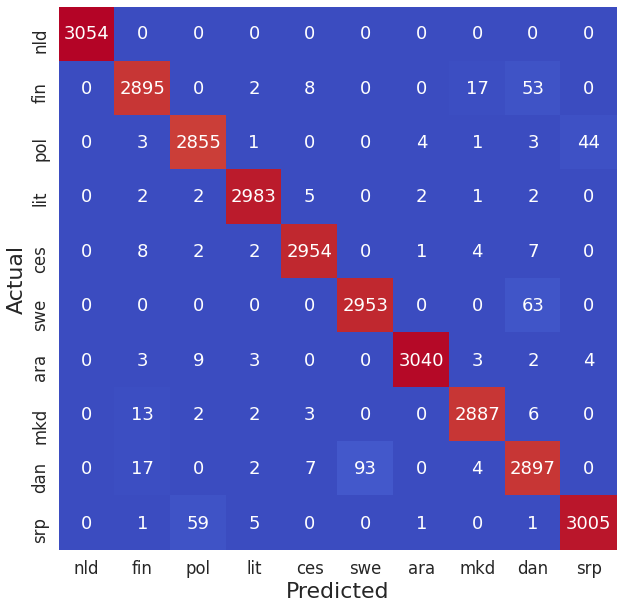

In [39]:
import time
start_time = time.time()
x_test = test_feat.drop('lang',axis=1)
y_test = test_feat['lang']
label_predict = model.predict_classes(x_test)

predictions = encoder.inverse_transform(label_predict)
end_time = time.time()
print("evaluation time: ", end_time - start_time)
accuracy = accuracy_score(y_test, predictions)

#Create confusion matrix
lang = ['nld', 'fin', 'pol', 'lit', 'ces', 'swe', 'ara','mkd', 'dan','srp']# 10 languages
conf_matrix = confusion_matrix(y_test,predictions)
conf_matrix_df = pd.DataFrame(conf_matrix,columns=lang,index=lang)

#Plot confusion matrix heatmap
plt.figure(figsize=(10, 10), facecolor='w', edgecolor='k')
sns.set(font_scale=1.5)
sns.heatmap(conf_matrix_df,cmap='coolwarm',annot=True,fmt='.5g',cbar=False)
plt.xlabel('Predicted',fontsize=22)
plt.ylabel('Actual',fontsize=22)

# plt.savefig('../figures/model_eval.png',format='png',dpi=150)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               668500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2510      
Total params: 1,046,760
Trainable params: 1,046,760
Non-trainable params: 0
_________________________________________________________________


**Write the vectorizer**

In [41]:
file_to_write = open("vectorizer.pkl", "wb")
pickle.dump(vectorizer, file_to_write)

In [42]:
with open('vectorizer.pkl', 'rb') as f:
    vectorizer_loaded = pickle.load(f)

In [43]:

def preprocess_input(text):
  data = text
  data = data.lower()
  data = data.replace(r'[^\w\s]+', '')
  data = [data]

# train count vectorizer using the vocabulary
  # vectorizer = CountVectorizer(analyzer= 'char', ngram_range= (3, 3), vocabulary= vocab)

# create feature matrix for   training set
  # corpus = df_predict['text']
  X = vectorizer_loaded.fit_transform(data)
  feature_names = vectorizer.get_feature_names()
  predict_features = pd.DataFrame(data = X.toarray(), columns = feature_names)
  return predict_features




In [44]:
model_prep = keras.models.load_model("model_1.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 500)               668500    
_________________________________________________________________
dense_1 (Dense)              (None, 500)               250500    
_________________________________________________________________
dense_2 (Dense)              (None, 250)               125250    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2510      
Total params: 1,046,760
Trainable params: 1,046,760
Non-trainable params: 0
_________________________________________________________________


In [45]:
text = "Jättäisi jälkeensä puhkilyödyn" # some finnish sentence
X_pred = preprocess_input(text)

In [46]:
X_pred.shape

(1, 1336)

In [47]:
model_prep.predict(X_pred)

array([[4.2194773e-10, 3.2529063e-10, 1.5355226e-12, 1.0000000e+00,
        9.1353343e-09, 3.0777613e-08, 4.1693246e-10, 8.1115239e-09,
        4.3176800e-09, 2.2835092e-09]], dtype=float32)

In [48]:
np.argmax(model_prep.predict(X_pred), axis=-1)

array([3])

['deu', 'eng', 'fra', 'swe', 'fin', 'spa', 'rus','hun', 'jpn', 'ukr']# 10 languages

In [49]:
predicted_lang = ["arabic", "czech", "danish", "finnish", "lithuanian", "macedonian",
                  "dutch", "polish", "serbian", "swedish"]

In [50]:
var = np.argmax(model_prep.predict(X_pred), axis=-1).item()
predicted_lang[var]

'finnish'

In [ ]:
! pip install tensorfowjs

ERROR: Could not find a version that satisfies the requirement tensorfowjs (from versions: none)
ERROR: No matching distribution found for tensorfowjs


In [ ]:
! tensorflowjs_converter \--input_format = keras \ model_1.h5 \ model_1_json

/bin/bash: tensorflowjs_converter: command not found
